In [47]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [48]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [49]:
class_names=sorted(os.listdir('iran-used-cars-dataset/split/train'))
print(class_names)
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names)) 

['Mazda-2000', 'Nissan-Zamiad', 'Peugeot-206', 'Peugeot-207i', 'Peugeot-405', 'Peugeot-Pars', 'Peykan', 'Pride-111', 'Pride-131', 'Quik', 'Renault-L90', 'Samand', 'Tiba2']
13


In [50]:
print(normal_mapping)


{'Mazda-2000': 0, 'Nissan-Zamiad': 1, 'Peugeot-206': 2, 'Peugeot-207i': 3, 'Peugeot-405': 4, 'Peugeot-Pars': 5, 'Peykan': 6, 'Pride-111': 7, 'Pride-131': 8, 'Quik': 9, 'Renault-L90': 10, 'Samand': 11, 'Tiba2': 12}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iran-used-cars-dataset/split/train/Mazda-2000
iran-used-cars-dataset/split/train/Mazda-2000\Mazda-2000 (1).jpg
Mazda-2000
0
iran-used-cars-dataset/split/train/Mazda-2000
iran-used-cars-dataset/split/train/Mazda-2000\Mazda-2000 (100).jpg
Mazda-2000
0
iran-used-cars-dataset/split/train/Mazda-2000
iran-used-cars-dataset/split/train/Mazda-2000\Mazda-2000 (101).jpg
Mazda-2000
0
iran-used-cars-dataset/split/train/Mazda-2000
iran-used-cars-dataset/split/train/Mazda-2000\Mazda-2000 (102).jpg
Mazda-2000
0
iran-used-cars-dataset/split/train/Mazda-2000
iran-used-cars-dataset/split/train/Mazda-2000\Mazda-2000 (103).jpg
Mazda-2000
0
iran-used-cars-dataset/split/train/Mazda-2000
iran-used-cars-dataset/split/train/Mazda-2000\Mazda-2000 (104).jpg
Mazda-2000
0
iran-used-cars-dataset/split/train/Mazda-2000
iran-used-cars-dataset/split/train/Mazda-2000\Mazda-2000 (105).jpg
Mazda-2000
0
iran-used-cars-dataset/split/train/Mazda-2000
iran-used-cars-dataset/split/train/Mazda-2000\Mazda-2000 (106).jpg
Mazda-2

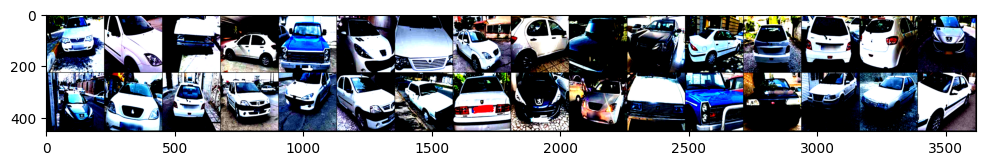

In [51]:
path_label=[]
for dirname, _, filenames in os.walk('iran-used-cars-dataset/split/train'):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            dirname=str(dirname.replace('\\','/'))
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            print(dirname)
            print(path)
            print(label)
            print(normal_mapping[label])
            path_label+=[(path,normal_mapping[label])]

vpath_label=[]
for dirname, _, filenames in os.walk('iran-used-cars-dataset/split/val'):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            dirname=str(dirname.replace('\\','/'))
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            vpath_label+=[(path,normal_mapping[label])]            
            
tpath_label=[]
for dirname, _, filenames in os.walk('iran-used-cars-dataset/split/test'):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            dirname=str(dirname.replace('\\','/'))
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            tpath_label+=[(path,normal_mapping[label])]
class ImageDataset(Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label
trainset = ImageDataset(path_label, transform)
valset = ImageDataset(vpath_label, transform)
testset = ImageDataset(tpath_label, transform)

labels = [label for _, label in trainset.path_label]

train_loader=DataLoader(trainset,batch_size=32,shuffle=True)
val_loader=DataLoader(valset,batch_size=32)
test_loader=DataLoader(testset,batch_size=32)
for images, labels in train_loader:
    break
im=make_grid(images,nrow=16)
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

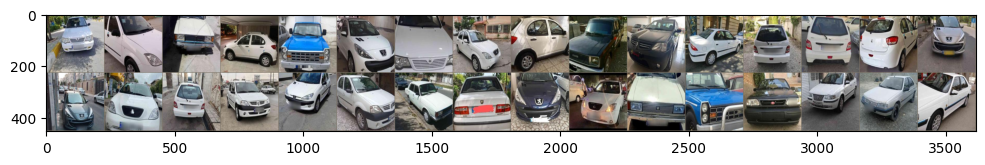

In [52]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [53]:
torch.manual_seed(42)

In [54]:
class MyModel(nn.Module):

    def __init__(self, model_name='skresnet34', pretrained=True):
        super(MyModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained, in_chans=3)
        self.fc1 = nn.Linear(1000,16)
        self.fc2 = nn.Linear(16,64)        
        self.fc3 = nn.Linear(64,len(class_names))
        
    def forward(self, x):
        #print(x.shape)
        x = self.model(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        #print(x.shape)
        return x
    
model2 = MyModel() 

In [55]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model2.parameters(),lr=0.001)
epochs=10

import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1        
        y_pred=model2(X_train)
        loss=criterion(y_pred,y_train)
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+= batch_corr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)
                  
    w s=criterion(y_val,y_test)
    loss=loss.detach().numpy()
    test_losses.append(loss)
    test_correct.append(tst_corr)
                  
print(f'\nDuration: {time.time() - start_time:.0f} seconds')      

epoch:  0  batch:  200 [  2000/8000]  loss: 0.85219699  accuracy: 191.050%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.36274138  accuracy: 280.600%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.10885634  accuracy: 294.700%
epoch:  3  batch:  200 [  2000/8000]  loss: 0.09630115  accuracy: 305.750%
epoch:  4  batch:  200 [  2000/8000]  loss: 0.13152727  accuracy: 305.200%
epoch:  5  batch:  200 [  2000/8000]  loss: 0.22414804  accuracy: 304.100%
epoch:  6  batch:  200 [  2000/8000]  loss: 0.13948676  accuracy: 311.250%
epoch:  7  batch:  200 [  2000/8000]  loss: 0.00020208  accuracy: 314.250%
epoch:  8  batch:  200 [  2000/8000]  loss: 0.02112115  accuracy: 310.700%
epoch:  9  batch:  200 [  2000/8000]  loss: 0.15595840  accuracy: 314.650%

Duration: 4085 seconds


In [84]:
import torch
from torchvision import transforms
from PIL import Image

# Assuming model2 is already defined and trained
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device=torch.device("cpu")
model2.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model2(test_images).argmax(dim=1)
        
        y_true.extend(test_labels.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

print("True labels:", y_true[:5])
print("Predicted labels:", y_pred[:5])


True labels: [0, 0, 0, 0, 0]
Predicted labels: [0, 0, 0, 0, 0]


In [83]:
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

               precision    recall  f1-score   support

   Mazda-2000     0.8273    0.9891    0.9010        92
Nissan-Zamiad     0.9263    0.9888    0.9565        89
  Peugeot-206     0.5571    0.9832    0.7112       119
 Peugeot-207i     0.9062    0.2589    0.4028       112
  Peugeot-405     0.9157    0.8539    0.8837        89
 Peugeot-Pars     1.0000    0.9018    0.9484       112
       Peykan     0.9402    0.9565    0.9483       115
    Pride-111     0.9007    0.9769    0.9373       130
    Pride-131     0.9636    0.9381    0.9507       113
         Quik     0.9516    0.7763    0.8551       152
  Renault-L90     0.9688    0.9490    0.9588        98
       Samand     0.9826    0.8898    0.9339       127
        Tiba2     0.8214    0.9127    0.8647       126

     accuracy                         0.8711      1474
    macro avg     0.8970    0.8750    0.8656      1474
 weighted avg     0.8968    0.8711    0.8633      1474



In [66]:
import torch
from torchvision import transforms
from PIL import Image


# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
model2.eval()

# Move model to the same device as input tensor
model2.to(device)



# Load the image
image_path = '1 (1).jpg'
image = Image.open(image_path).convert('RGB')

# Apply transformations
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Move input tensor to the same device as the model
input_image = input_image.to(device)

# Set your model to evaluation mode


# Make prediction
with torch.no_grad():
    output = model2(input_image)

# Get predicted class index
predicted_index = torch.argmax(output).item()

# Map index to class name
predicted_class = reverse_mapping[predicted_index]

print("Predicted class:", predicted_class)


Predicted class: Peugeot-206


In [81]:



import warnings
warnings.filterwarnings("ignore")
from PIL import Image


# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
loaded_model.eval()

# Move model to the same device as input tensor
loaded_model.to(device)


# Get the current directory
dir_path = os.getcwd()

# List all the files in the directory
files = os.listdir(dir_path)

# Filter the files with .png or .jpg extension
image_files = [file for file in files if file.endswith(('.png', '.jpg'))]

# Print the list of image files
print(image_files)


for item in image_files:
    image_path = item
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    input_image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move input tensor to the same device as the model
    input_image = input_image.to(device)

    # Set your model to evaluation mode


    # Make prediction
    with torch.no_grad():
        output = model2(input_image)

    # Get predicted class index
    predicted_index = torch.argmax(output).item()

    # Map index to class name
    predicted_class = reverse_mapping[predicted_index]

    print(item, ':',predicted_class)

['206 (1).jpg', '206 (2).jpg', '206 (3).jpg', '207 2.jpg', '207 erfan zoom.png', '207 erfan.jpg', 'l90 (1) haji.png', 'l90 (1).jpg', 'l90 (2) haji.jpg', 'l90 (3).jpg', 'nissan (1).jpg', 'nissan (1).png', 'nissan (2).jpg', 'nissan (3).jpg', 'pars (1).jpg', 'pars (1).png', 'pars (2).jpg', 'pars (2).png', 'pars (3).png', 'Peugeot-207i (1).jpg', 'Peugeot-207i (2).jpg', 'pride (1).jpg', 'pride (1).png', 'pride (2).jpg', 'pride (2).png', 'pride (3).jpg', 'pride (3).png', 'pride (4).jpg', 'pride.jpg', 'Renault-L90 (169).jpg', 'Renault-L90 (176).jpg', 'samand.jpg', 'samand.png', 'samandd.png', 'slx.png']
206 (1).jpg : Peugeot-206
206 (2).jpg : Peugeot-206
206 (3).jpg : Peugeot-206
207 2.jpg : Mazda-2000
207 erfan zoom.png : Peugeot-207i
207 erfan.jpg : Peugeot-206
l90 (1) haji.png : Renault-L90
l90 (1).jpg : Renault-L90
l90 (2) haji.jpg : Renault-L90
l90 (3).jpg : Renault-L90
nissan (1).jpg : Nissan-Zamiad
nissan (1).png : Nissan-Zamiad
nissan (2).jpg : Nissan-Zamiad
nissan (3).jpg : Nissan-Za

In [72]:
torch.save(model2, 'accepted.pth')

In [79]:
import __main__



In [80]:
import os
import torch
from torchvision import transforms
from PIL import Image
import os
import torch
from torchvision import transforms
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
loaded_model = torch.load('accepted.pth')
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
loaded_model.eval()

# Move model to the same device as input tensor
loaded_model.to(device)


# Get the current directory
dir_path = os.getcwd()

# List all the files in the directory
files = os.listdir(dir_path)

# Filter the files with .png or .jpg extension
image_files = [file for file in files if file.endswith(('.png', '.jpg'))]

# Print the list of image files
print(image_files)


for item in image_files:
    image_path = item
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    input_image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move input tensor to the same device as the model
    input_image = input_image.to(device)

    # Set your model to evaluation mode


    # Make prediction
    with torch.no_grad():
        output = loaded_model(input_image)

    # Get predicted class index
    predicted_index = torch.argmax(output).item()

    # Map index to class name
    predicted_class = reverse_mapping[predicted_index]

    print(item, ':',predicted_class)

['206 (1).jpg', '206 (2).jpg', '206 (3).jpg', '207 2.jpg', '207 erfan zoom.png', '207 erfan.jpg', 'l90 (1) haji.png', 'l90 (1).jpg', 'l90 (2) haji.jpg', 'l90 (3).jpg', 'nissan (1).jpg', 'nissan (1).png', 'nissan (2).jpg', 'nissan (3).jpg', 'pars (1).jpg', 'pars (1).png', 'pars (2).jpg', 'pars (2).png', 'pars (3).png', 'Peugeot-207i (1).jpg', 'Peugeot-207i (2).jpg', 'pride (1).jpg', 'pride (1).png', 'pride (2).jpg', 'pride (2).png', 'pride (3).jpg', 'pride (3).png', 'pride (4).jpg', 'pride.jpg', 'Renault-L90 (169).jpg', 'Renault-L90 (176).jpg', 'samand.jpg', 'samand.png', 'samandd.png', 'slx.png']
206 (1).jpg : Peugeot-206
206 (2).jpg : Peugeot-206
206 (3).jpg : Peugeot-206
207 2.jpg : Mazda-2000
207 erfan zoom.png : Peugeot-207i
207 erfan.jpg : Peugeot-206
l90 (1) haji.png : Renault-L90
l90 (1).jpg : Renault-L90
l90 (2) haji.jpg : Renault-L90
l90 (3).jpg : Renault-L90
nissan (1).jpg : Nissan-Zamiad
nissan (1).png : Nissan-Zamiad
nissan (2).jpg : Nissan-Zamiad
nissan (3).jpg : Nissan-Za

Predicted class: Peykan


In [139]:
import torch
from torchvision import transforms
from PIL import Image

# Define the file path from where you want to load the model
saved_model_path = 'final.pth'

# Initialize a new model instance
model = MyModel()

# Load the saved model state dictionary
checkpoint = torch.load(saved_model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

# Set the model to evaluation mode
model.eval()

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image you want to classify
image_path = '207.jpg'
image = Image.open(image_path).convert('RGB')

# Apply transformations to preprocess the image
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Move input tensor to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_image = input_image.to(device)

# Move the model to the same device as the input tensor
model.to(device)

# Make prediction
with torch.no_grad():
    output = model(input_image)

# Get predicted class index
predicted_index = torch.argmax(output).item()

# Map index to class name
predicted_class = reverse_mapping[predicted_index]

print("Predicted class:", predicted_class)


Predicted class: Peykan
